In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random

# Data Preparation

### Create dataset

In [71]:
# Create datasets

dementia_image_paths = os.listdir('/Users/aatyanth/COGS181/Data/Dementia')
no_dementia_image_paths = os.listdir('/Users/aatyanth/COGS181/Data/No_Dementia')

patient_ids = []
class_labels = []
image_paths = []
prefix = '/Data/Dementia/'

for path in dementia_image_paths:
    patient_id = path.split('_')[1]
    if patient_id not in patient_ids:
        patient_subset = [path for path in dementia_image_paths if path.split('_')[1] == patient_id]
        chosen = random.choices(patient_subset, k=16)
        for p in chosen:
            image_paths.append(prefix + p)
        for i in range(16):
            patient_ids.append(patient_id)
            class_labels.append(1)
    else:
        continue
    

prefix = '/Data/No_Dementia/'
tracker = 0
for path in no_dementia_image_paths:
    patient_id = path.split('_')[1]
    if patient_id not in patient_ids:
        patient_subset = [path for path in no_dementia_image_paths if path.split('_')[1] == patient_id]
        chosen = random.choices(patient_subset, k=16)
        tracker += 1
        if tracker > 81:
            break
        for p in chosen:
            image_paths.append(prefix + p)
        for i in range(16):
            patient_ids.append(patient_id)
            class_labels.append(0)
    else:
        continue


In [72]:
df = pd.DataFrame([patient_ids, image_paths, class_labels]).transpose()
df.columns = ['patient_id', 'image_path', 'class_label']
df

,patient_id,image_path,class_label
0,0023,/Data/Dementia/OAS1_0023_MR1_mpr-1_129.jpg,1
1,0023,/Data/Dementia/OAS1_0023_MR1_mpr-2_111.jpg,1
2,0023,/Data/Dementia/OAS1_0023_MR1_mpr-3_156.jpg,1
3,0023,/Data/Dementia/OAS1_0023_MR1_mpr-1_147.jpg,1
4,0023,/Data/Dementia/OAS1_0023_MR1_mpr-3_102.jpg,1
...,...,...,...
2587,0327,/Data/No_Dementia/OAS1_0327_MR1_mpr-1_104.jpg,0
2588,0327,/Data/No_Dementia/OAS1_0327_MR1_mpr-3_156.jpg,0
2589,0327,/Data/No_Dementia/OAS1_0327_MR1_mpr-1_103.jpg,0
2590,0327,/Data/No_Dementia/OAS1_0327_MR1_mpr-1_103.jpg,0


### Train-Test Split (based on random selection of patients done in data_exploration.ipynb)

In [73]:
random.seed(42)
# Create separate dataframes for each class
class_0_df = df[df['class_label'].isin([0])]
class_1_df = df[df['class_label'].isin([1])]

train_choices_0 = random.sample(class_0_df['patient_id'].unique().tolist(), k=57)
train_choices_1 = random.sample(class_1_df['patient_id'].unique().tolist(), k=57)

test_choices_0 = []
for id in class_0_df['patient_id'].unique():
    if (id not in train_choices_0) and (id not in test_choices_0):
        test_choices_0.append(id)
    else:
        continue
test_choices_1 = []
for id in class_1_df['patient_id'].unique():
    if (id not in train_choices_1) and (id not in test_choices_1):
        test_choices_1.append(id)
    else:
        continue

print("Patient IDs for training set from class 0: ", train_choices_0)
print("Patient IDs for training set from class 1: ", train_choices_1)
print()
print("Patient IDs for testing set from class 0: ", test_choices_0)
print("Patient IDs for testing set from class 1: ", test_choices_1)
print()

#Check that train and test sets have no overlapping participants
compare_0 = np.intersect1d(np.array(train_choices_0), np.array(test_choices_0))
if len(compare_0) > 0:
    print('INTERSECTING PATIENT ID\'S')
else:
    print("No intersecting ID\'s")
    
compare_1 = np.intersect1d(np.array(train_choices_1), np.array(test_choices_1))
if len(compare_1) > 0:
    print('INTERSECTING PATIENT ID\'S')
else:
    print("No intersecting ID\'s")
print()

# Create the training set dataframe
train_df = df[df['patient_id'].isin(train_choices_0 + train_choices_1)]
train_df = train_df.reset_index()
print("Number of participants in training set: ", int(len(train_df) / 16))

# Create the testing set dataframe
test_df = df[df['patient_id'].isin(test_choices_0 + test_choices_1)]
test_df = test_df.reset_index()
print("Number of participants in testing set: ", int(len(test_df) / 16))

print('Train Ratio: ', (len(train_df) / len(df)))
print('Test Ratio: ', (len(test_df) / len(df)))

Patient IDs for training set from class 0:  ['0026', '0182', '0254', '0043', '0289', '0369', '0141', '0319', '0356', '0202', '0132', '0236', '0296', '0224', '0253', '0088', '0156', '0077', '0162', '0331', '0069', '0076', '0195', '0327', '0354', '0295', '0353', '0350', '0349', '0140', '0146', '0323', '0301', '0346', '0190', '0096', '0034', '0114', '0144', '0055', '0294', '0368', '0086', '0121', '0068', '0234', '0111', '0229', '0002', '0101', '0178', '0133', '0097', '0330', '0213', '0074', '0214']
Patient IDs for training set from class 1:  ['0052', '0179', '0351', '0243', '0166', '0380', '0300', '0003', '0056', '0290', '0021', '0134', '0298', '0142', '0226', '0307', '0073', '0291', '0304', '0238', '0185', '0335', '0312', '0042', '0094', '0205', '0184', '0382', '0143', '0247', '0273', '0084', '0362', '0124', '0308', '0269', '0286', '0046', '0373', '0122', '0240', '0120', '0158', '0015', '0028', '0098', '0066', '0374', '0082', '0161', '0288', '0115', '0267', '0217', '0039', '0352', '0339'

# Data Pipeline

### Defining Transforms

In [74]:
# Importing the custom dataset class
from alzheimers_dataset import alzheimers_dataset
import torchvision.transforms as tf

In [75]:
# Simple transforms for baseline model
transforms = tf.Compose([
    tf.Pad([0, 124,]),
    tf.ToTensor(),
    ])

In [76]:
# Create datasets based on custom dataset class
root_dir = '/Users/aatyanth/COGS181'

train_image_paths = train_df['image_path'].to_numpy()
train_labels = train_df['class_label'].to_numpy()
train_set = alzheimers_dataset(root_dir=root_dir, image_paths=train_image_paths, labels=train_labels, transform=transforms)
test_image_paths = test_df['image_path'].to_numpy()
test_labels = test_df['class_label'].to_numpy()
test_set = alzheimers_dataset(root_dir=root_dir, image_paths=test_image_paths, labels=test_labels, transform=transforms)

# Set up DataLoaders for train and test set
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=True, num_workers=2, drop_last=True)

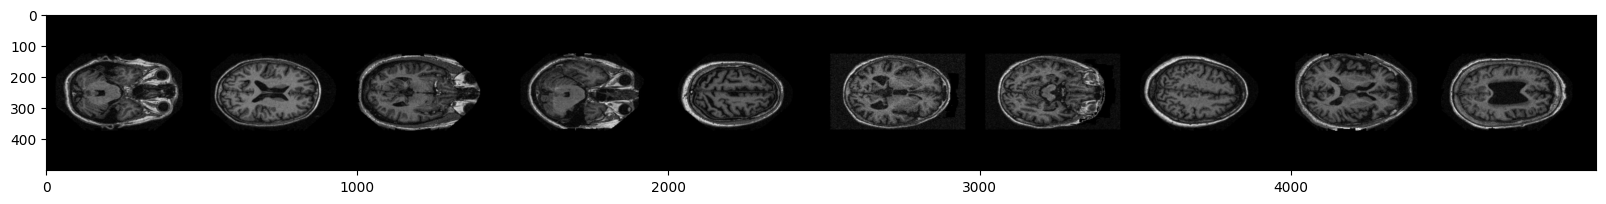

Alzheimers   No Alzheimers   No Alzheimers   No Alzheimers   Alzheimers   No Alzheimers   No Alzheimers   Alzheimers   Alzheimers   Alzheimers


In [86]:
# Test how the images look

# Function to show image
def show_image(img):
    img = img.numpy()
    plt.figure(figsize=(20, 4))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

iteration = iter(train_loader)
images, labels = next(iteration)

show_image(torchvision.utils.make_grid(images, nrow=10))
classes = ("No Alzheimers", "Alzheimers")
print("   ".join('%5s' % classes[labels[j]] for j in range(10)))


# Model Implementation

### Implement AlzheimersNet Class

In [87]:
class AlzheimersNet(nn.Module):
    
    def __init__(self):
        super(AlzheimersNet, self).__init__()
        
        # Initializing Convolution Blocks
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.pool = nn.AvgPool2d(kernel_size=3, stride=3)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        
        # Initializing Linear Layers
        self.fc1 = nn.Linear(in_features=(64*18*18), out_features=512)
        self.dropout = nn.Dropout()
        
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 2)
    
    def forward(self, x):
        
        # implement the convolution blocks
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the layers
        flattened = torch.flatten(x, start_dim=1)
        # implement the fully connected network
        x = F.relu(self.fc1(flattened))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        # Store the output of the FCN
        output = F.relu(self.fc4(x))
        
        return output

# Training Implementation

In [88]:
# Choose the device
device = torch.device("cuda0" if torch.cuda.is_available() else "cpu")

# Create an instance of the Network
cnn = AlzheimersNet()

# Loss and optimizer to use
loss_func = nn.CrossEntropyLoss()
sgd = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

# Moving network parameters to the chosen device
cnn.to(device)

AlzheimersNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=20736, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
)

In [89]:
from tqdm import tqdm
# Training Procedure

avg_losses = []
epochs = 5
print_freq = 10
predictions_list = []

for epoch in tqdm(range(epochs), desc="Training Completion"):
    running_loss = 0.0
    for batch, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zeroing the gradients
        sgd.zero_grad()
        
        # Generate predictions
        outputs = cnn(inputs)
        
        # Compute loss based on predictions and ground truth
        loss = loss_func(outputs, labels)
        
        # Take backwards step
        loss.backward()
        
        # Update the network parameters
        sgd.step()
        
        running_loss += loss.item()
        
        if batch % print_freq == print_freq - 1:
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, batch, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Training Complete.')

Training Completion:   0%|          | 0/5 [00:00<?, ?it/s]

[epoch: 0, i:     9] avg mini-batch loss: 0.693
[epoch: 0, i:    19] avg mini-batch loss: 0.687
[epoch: 0, i:    29] avg mini-batch loss: 0.674
[epoch: 0, i:    39] avg mini-batch loss: 0.662
[epoch: 0, i:    49] avg mini-batch loss: 0.674
[epoch: 0, i:    59] avg mini-batch loss: 0.667
[epoch: 0, i:    69] avg mini-batch loss: 0.681
[epoch: 0, i:    79] avg mini-batch loss: 0.675
[epoch: 0, i:    89] avg mini-batch loss: 0.672
[epoch: 0, i:    99] avg mini-batch loss: 0.697
[epoch: 0, i:   109] avg mini-batch loss: 0.709
[epoch: 0, i:   119] avg mini-batch loss: 0.674
[epoch: 0, i:   129] avg mini-batch loss: 0.673
[epoch: 0, i:   139] avg mini-batch loss: 0.674
[epoch: 0, i:   149] avg mini-batch loss: 0.661
[epoch: 0, i:   159] avg mini-batch loss: 0.655
[epoch: 0, i:   169] avg mini-batch loss: 0.606
[epoch: 0, i:   179] avg mini-batch loss: 0.601


Training Completion:  20%|██        | 1/5 [01:11<04:46, 71.75s/it]

[epoch: 1, i:     9] avg mini-batch loss: 0.611
[epoch: 1, i:    19] avg mini-batch loss: 0.602
[epoch: 1, i:    29] avg mini-batch loss: 0.521
[epoch: 1, i:    39] avg mini-batch loss: 0.535
[epoch: 1, i:    49] avg mini-batch loss: 0.576
[epoch: 1, i:    59] avg mini-batch loss: 0.562
[epoch: 1, i:    69] avg mini-batch loss: 0.510
[epoch: 1, i:    79] avg mini-batch loss: 0.574
[epoch: 1, i:    89] avg mini-batch loss: 0.577
[epoch: 1, i:    99] avg mini-batch loss: 0.546
[epoch: 1, i:   109] avg mini-batch loss: 0.545
[epoch: 1, i:   119] avg mini-batch loss: 0.508
[epoch: 1, i:   129] avg mini-batch loss: 0.486
[epoch: 1, i:   139] avg mini-batch loss: 0.484
[epoch: 1, i:   149] avg mini-batch loss: 0.552
[epoch: 1, i:   159] avg mini-batch loss: 0.480
[epoch: 1, i:   169] avg mini-batch loss: 0.377
[epoch: 1, i:   179] avg mini-batch loss: 0.467


Training Completion:  40%|████      | 2/5 [02:23<03:35, 71.77s/it]

[epoch: 2, i:     9] avg mini-batch loss: 0.581
[epoch: 2, i:    19] avg mini-batch loss: 0.489
[epoch: 2, i:    29] avg mini-batch loss: 0.509
[epoch: 2, i:    39] avg mini-batch loss: 0.474
[epoch: 2, i:    49] avg mini-batch loss: 0.494
[epoch: 2, i:    59] avg mini-batch loss: 0.505
[epoch: 2, i:    69] avg mini-batch loss: 0.365
[epoch: 2, i:    79] avg mini-batch loss: 0.398
[epoch: 2, i:    89] avg mini-batch loss: 0.406
[epoch: 2, i:    99] avg mini-batch loss: 0.482
[epoch: 2, i:   109] avg mini-batch loss: 0.456
[epoch: 2, i:   119] avg mini-batch loss: 0.455
[epoch: 2, i:   129] avg mini-batch loss: 0.398
[epoch: 2, i:   139] avg mini-batch loss: 0.364
[epoch: 2, i:   149] avg mini-batch loss: 0.548
[epoch: 2, i:   159] avg mini-batch loss: 0.440
[epoch: 2, i:   169] avg mini-batch loss: 0.433
[epoch: 2, i:   179] avg mini-batch loss: 0.545


Training Completion:  60%|██████    | 3/5 [03:37<02:25, 72.75s/it]

[epoch: 3, i:     9] avg mini-batch loss: 0.528
[epoch: 3, i:    19] avg mini-batch loss: 0.400
[epoch: 3, i:    29] avg mini-batch loss: 0.381
[epoch: 3, i:    39] avg mini-batch loss: 0.394
[epoch: 3, i:    49] avg mini-batch loss: 0.456
[epoch: 3, i:    59] avg mini-batch loss: 0.371
[epoch: 3, i:    69] avg mini-batch loss: 0.366
[epoch: 3, i:    79] avg mini-batch loss: 0.394
[epoch: 3, i:    89] avg mini-batch loss: 0.405
[epoch: 3, i:    99] avg mini-batch loss: 0.430
[epoch: 3, i:   109] avg mini-batch loss: 0.331
[epoch: 3, i:   119] avg mini-batch loss: 0.395
[epoch: 3, i:   129] avg mini-batch loss: 0.386
[epoch: 3, i:   139] avg mini-batch loss: 0.292
[epoch: 3, i:   149] avg mini-batch loss: 0.344
[epoch: 3, i:   159] avg mini-batch loss: 0.417
[epoch: 3, i:   169] avg mini-batch loss: 0.448
[epoch: 3, i:   179] avg mini-batch loss: 0.283


Training Completion:  80%|████████  | 4/5 [04:49<01:12, 72.39s/it]

[epoch: 4, i:     9] avg mini-batch loss: 0.383
[epoch: 4, i:    19] avg mini-batch loss: 0.389
[epoch: 4, i:    29] avg mini-batch loss: 0.399
[epoch: 4, i:    39] avg mini-batch loss: 0.429
[epoch: 4, i:    49] avg mini-batch loss: 0.335
[epoch: 4, i:    59] avg mini-batch loss: 0.314
[epoch: 4, i:    69] avg mini-batch loss: 0.289
[epoch: 4, i:    79] avg mini-batch loss: 0.295
[epoch: 4, i:    89] avg mini-batch loss: 0.368
[epoch: 4, i:    99] avg mini-batch loss: 0.324
[epoch: 4, i:   109] avg mini-batch loss: 0.424
[epoch: 4, i:   119] avg mini-batch loss: 0.319
[epoch: 4, i:   129] avg mini-batch loss: 0.284
[epoch: 4, i:   139] avg mini-batch loss: 0.357
[epoch: 4, i:   149] avg mini-batch loss: 0.402
[epoch: 4, i:   159] avg mini-batch loss: 0.450
[epoch: 4, i:   169] avg mini-batch loss: 0.322
[epoch: 4, i:   179] avg mini-batch loss: 0.317


Training Completion: 100%|██████████| 5/5 [06:07<00:00, 73.45s/it]

Training Complete.


### Training Loss Curve

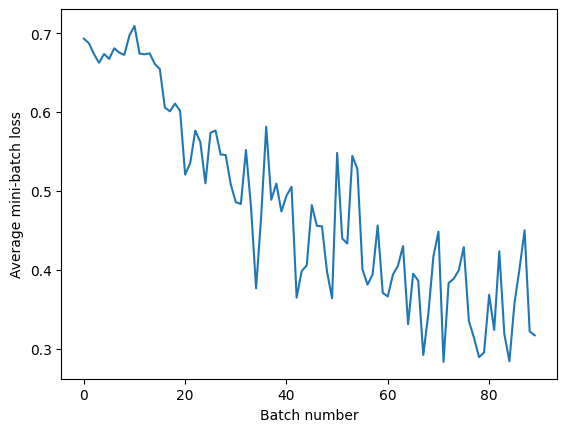

In [90]:
plt.plot(avg_losses)
plt.xlabel("Batch number")
plt.ylabel("Average mini-batch loss")
plt.show()

# Evaluation

In [91]:
# Test Accuracy

total_samples = 0
correct_predictions = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = cnn(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total_samples += labels.size(0)
        
        correct_predictions += (predicted == labels).sum().item()
        
        

print("Accuracy of the Network on Test Data: ", (100 * (correct_predictions/total_samples)))

Accuracy of the Network on Test Data:  79.21052631578948


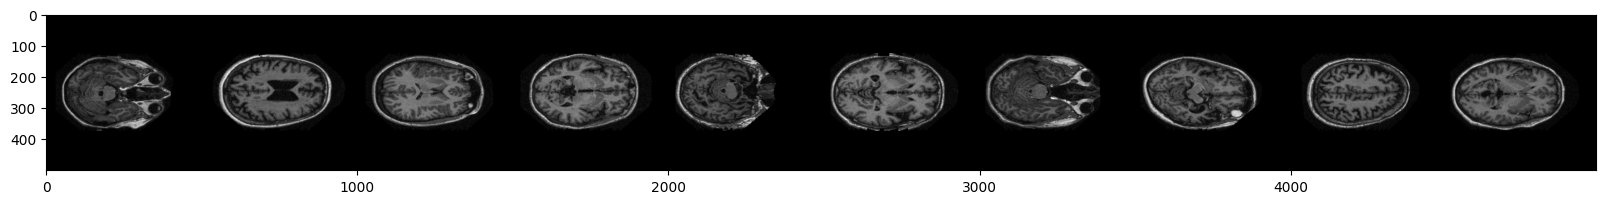

Predictions:   No Alzheimers Alzheimers No Alzheimers No Alzheimers Alzheimers Alzheimers No Alzheimers Alzheimers Alzheimers No Alzheimers
Ground Truth:  No Alzheimers Alzheimers No Alzheimers Alzheimers Alzheimers Alzheimers No Alzheimers Alzheimers Alzheimers No Alzheimers


In [95]:
# Visualize a few predictions
iteration = iter(test_loader)
images, labels = next(iteration)
images, labels = next(iteration)
show_image(torchvision.utils.make_grid(images, nrow=10))
outputs = cnn(images.to(device))
_, predictions = torch.max(outputs.data, 1)
classes = ("No Alzheimers", "Alzheimers")
print("Predictions:  ", " ".join('%5s' % classes[predictions[i]] for i in range(10)))
print("Ground Truth: ", " ".join('%5s' % classes[labels[j]] for j in range(10)))

In [93]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of No Alzheimers : 70 %
Accuracy of Alzheimers : 87 %
